**Note importante pour une comparaison optimale des résultats**

Les graphiques dans ce notebook utilisent la librairie [plotly](https://plot.ly/python/) et sont donc intéractifs. Il est par exemple possible de masquer une courbe en cliquant sur sa légende, ou encore d'en sélectionner une seule en double-cliquant sur sa légende.

**DEBERNARDI - FERSULA**


# **Évaluation du risque par une méthode de Monte Carlo et tests par permutations**

L'objectif de ce TP est de regarder le test de comparaison de deux moyennes à partir de deux échantillons indépendants.
Les données forment un vecteur $(x_1,\ldots, x_m, y_1,\ldots, y_n)$ de longueur $m+n$. Elles concernent l'effet d'un traitement médical sur $m+n$ patients. Les $m=13$ premiers patients ont reçu le médicament $A$, qui est le traitement de référence. Les $n=16$ autres patients ont reçu le médicament $B$, qui est le nouveau traitement. L'objectif de l'étude est de savoir si ce médicament $B$ est plus efficace que le traitement de référence.

Les données sont :
$x_{1:m}^\text{obs} = (-3.06, -0.71, 11.99, 1.42, 1.84, 13.1, 4.19, -8.06, -3.96, -2.24, 9.61, 3.47, 3.77)$ et $y_{1:n}^\text{obs} = (12.57, 7.44, 2.97, 10.35, 10.24, 9.89, 9.07, 8.23, 4.42, 2.9, 2.44, 0.49, 3.51, -3.05, 18.25, 12.29)$.

On modélise ces données $(x_1,\ldots, x_m, y_1,\ldots, y_n)$ par le vecteur de variables aléatoires $(X_1,\ldots, X_m, Y_1,\ldots, Y_n)$. On suppose que ces $m+n$ variables sont indépendantes, que les $X_i$ ont tous même loi, d'espérance $\mu_X$ et que les $Y_j$ ont tous même loi, d'espérance
$\mu_X+\Delta$.

On s'intéresse aux  hypothèses $H_0: \Delta \le 0 \quad \textit{vs} \quad H_1~: \Delta>0$.

In [0]:
# permet d'obtenir le temps d'exécution de chacune des cellules du notebook
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=a4afa507e8b9050c008639104924f1570b3ab8858f86b648f4b1fd149327dcb2
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [0]:
import numpy as np
import scipy.stats as stats
import plotly.graph_objects as go
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression

time: 2.05 s


## **Partie 1 : Test de Student sous hypothèse gaussienne**

### **1.1** Justifier du choix de $\Delta \le 0$ comme hypothèse nulle.

On cherche à savoir si le traitement B est plus efficace que le A. Sous l'hypothèse ($\Delta \le 0$), l'efficacité moyenne du traitement B n'est pas meilleure que celle du traitement A. On pose donc comme hypothèse nulle $H_0 : \Delta \le 0$ afin de ne pas avoir de perte d'efficacité en cas d'erreur (autrement dit, on préfère conserver A si on est pas suffisamment certain de la supériorité de B). 

On cherchera par la suite à calculer $P(H_1 | H_0)$ la probabilité qui nous indique à quel point on aurait tort de croire en l'hypothèse $H_0$ plutôt qu'en $H_1$.

### **1.2** Justifier du choix de la statistique de test T.

T est une bonne statistique de test car :

* (a) On peut calculer T sans connaître la vraie valeur de $\theta = \{\mu_X, \sigma^2, \Delta\}$ .
    * T dépend uniquement des observations.

* (b) Le comportement de T sous ($H_0$) et sous ($H_1$) est différent.
    * On attend de T qu'il soit $\le$ 0 lorsque $\Delta \le 0$ et > 0 lorsque $\Delta > 0$.

* (c) La loi de $T$ sous les pires cas est entièrement connue.
    * Dans le pire cas $\Delta = 0$, $T$ suit une loi de Student à $m+n-2$ degrés de liberté.

* (d) Le comportement de T est connu lorsqu'on s'éloigne de ($H_0$).
    * T est croissant en $\Delta$.

### **1.3** Justifier que la zone de rejet soit de la forme [c; +$\infty$] où c est une constante à déterminer.

On rejette l'hypothèse nulle après un test de taille $\alpha$ si $P(H_1 | H_0) > 1 - \alpha $. Soit $c \in \textbf{R}^+$

On a : $\Delta > 0 \iff T > 0$.

$P(H_1 | H_0) = P(\Delta > 0 | H_0) = P(T > 0 | H_0) \geq P(T>c)$

 et on a : $ P(T>c) > 1 - \alpha \implies P(H_1 | H_0) > 1 - \alpha$ 

D'où une zone de rejet de la forme [c; +$\infty$].


### **1.4** On note $\Phi_{m+n-2}$ la fonction de répartition de la loi de Student à $m+n-2$ degrés de liberté. Montrer que, si l'on fixe la taille du test à $\alpha$, il faut choisir $c=\Phi_{m+n-2}^{-1}(1-\alpha)$.

On veut $P(H_1 | H_0) = \alpha$

 $\iff P(\bar Y - \bar X > \epsilon) = \alpha$

$ \iff P(\bar Y - \bar X < \epsilon) = 1- \alpha$

$\iff P(T < c) = 1- \alpha$ avec c = $\frac{\epsilon}{\sqrt{S_p^2\left(\frac1m+\frac1n\right)}}$

$\iff \Phi_{m+n-2}(c) = 1-\alpha$

$\iff c=\Phi_{m+n-2}^{-1}(1-\alpha)$



### **1.5** Ecrire une fonction (sans boucle for explicite), nommée calculeT qui calcule la valeur observée de T, à partir de deux entrées : le vecteur des $x_i$ et le vecteur des $y_i$. Que vaut la valeur observée $t^{obs}$ ici ?


In [0]:
def calculeT(x1, x2):
    """
    Modélise un test pour comparer deux moyennes sous hypothèse gaussienne.
    
    Hypothèse nulle    : H0 (mu1 >= mu2)
    Hypothèse à tester : H1 (mu1 <  mu2)
    P-valeur           : valeur maximum du pourcentage au-delà duquel je ne
                         peux plus rejeter H1.
    
    Parameters
    ----------
    x1 : array-like
    x2 : array-like
    """
    assert len(x1) > 0, 'x1 doit contenir des données'
    assert len(x2) > 0, 'x2 doit contenir des données'

    mu1 = x1.mean()
    mu2 = x2.mean()

    student_law_degree = (len(x1) + len(x2) - 2)

    # on calcule la somme des variances pour éviter de diviser par la taille
    # puis de re-multiplier lors du calcul de S
    var1 = ((x1 - mu1)**2).sum()
    var2 = ((x2 - mu2)**2).sum()

    S = (var1 + var2) / student_law_degree
    denom = np.sqrt(S * (1/len(x1) + 1/len(x2)))

    return (mu2 - mu1) / denom

def calculePvalue(t_obs, student_law_degree):
    """
    Parameters
    ----------
    x1 : integer
    x2 : integer
    """
    return 1 - stats.t.cdf(t_obs, student_law_degree)

time: 16.1 ms


* Tests de vérification en fonction de la valeur de $\Delta$

In [0]:
def tests_selon_delta(deltas):
    """
    Parameters
    ----------
    deltas : array-like
    """
    for delta in deltas:
        x1 = np.random.normal(0, 1, size=(1000))
        x2 = np.random.normal(delta, 1, size=(1000))
        
        t_obs = calculeT(x1, x2)
        p_value = calculePvalue(t_obs, len(x1)+len(x2)-2)

        print(f"* delta = {delta}")
        print(f"\t t_obs={t_obs}")
        print(f"\t p_value={p_value}\n")

tests_selon_delta(deltas=[1, -1, 0.1, -0.1])

* delta = 1
	 t_obs=23.12003402588662
	 p_value=0.0

* delta = -1
	 t_obs=-22.75123747786564
	 p_value=1.0

* delta = 0.1
	 t_obs=3.2566363505943525
	 p_value=0.0005731407723742477

* delta = -0.1
	 t_obs=-1.5617263614192738
	 p_value=0.9407445834273733

time: 31.3 ms


* Test de vérification de la valeur de la $p$-value en fonction de delta

In [0]:
start = -5
end = 5
t_obs_range = np.arange(start, end)

values = []
for t_obs in t_obs_range:
    values.append(calculePvalue(t_obs, 27))

fig = go.Figure(
    data=[
        go.Scatter(
            y=values
        )
    ],
    layout={
        'legend': {
            'orientation': 'h'
        },
    }
)
fig.show()

time: 1.38 s


In [0]:
# ---
# données utilisées dans la partie 1
# ---
x1 = np.array([
    -3.06, -0.71, 11.99, 1.42, 1.84, 13.1, 4.19, -8.06, -3.96, -2.24,
    9.61, 3.47, 3.77
])
x2 = np.array([
    12.57, 7.44, 2.97, 10.35, 10.24, 9.89, 9.07, 8.23, 4.42, 2.9,
    2.44, 0.49, 3.51, -3.05, 18.25, 12.29
])

student_law_degree = len(x1)+len(x2)-2

t_obs = calculeT(x1, x2)
print(f"Réponse question 5, t_obs={t_obs}")

Réponse question 5, t_obs=2.1114119537498905
time: 6.89 ms


# **1.6** En utilisant les fonctions de scipy.stats, calculer $c$ dans notre cas si $\alpha = 0.05$. Quelle décision prend le test de Student ?

In [0]:
print(f"Réponse question 6, c={stats.t.ppf(0.95, student_law_degree)}")

Réponse question 6, c=1.7032884457221265
time: 7.01 ms


On a $t^{obs} > c$, on prend donc la décision alternative, en rejetant l'hypothèse nulle. En effet, on a calculé précédement que si l'hypothèse nulle $H_0$ est vraie, on a $P(T > c) =\alpha = 0.05$, il est donc plus probable que $H_0$ soit fausse.

# **1.7** Montrer que la $p$-value est donnée ici par $p(X,Y) = 1 - \Phi_{m+n-2}(T)$. Quelle est la valeur observée de la $p$-value ?

On cherche $p$ la valeur du plus petit test que nos données nous permettent de passer. Autrement dit, on cherche à minimiser $\alpha = P(T > c)$ d'après **1.4**. Comme $P(T > c) =P(T \geq c)$ est décroissant en $c$, il suffit de choisir $c = T$ pour minimiser $\alpha$. De plus, on sait que $c =1 - \Phi^{-1}_{m+n-2}(\alpha) \iff  \alpha = 1 - \Phi_{m+n-2}(c) $ d'où $p = 1 - \Phi_{m+n-2}(T)$.

In [0]:
p_value = calculePvalue(t_obs, student_law_degree)
print(f"Réponse question 7, p_value={p_value}")

Réponse question 7, p_value=0.02206763583900795
time: 7.28 ms


# **Partie 2 : Étude de la puissance du test de Student**

## **2.1** $\star$ Montrer que la loi de $T$ ne dépend pas de $\mu_X$, mais uniquement de $\Delta$ et $\sigma^2$. Dans toute la suite, on fixera $\mu_X = 0.92$ si on a besoin d'une valeur numérique.

On note X$_1$ $\sim N\Big(\mu_1, \sigma^2\Big)$, Y$_1$ $\sim N\Big(\mu_1 + \Delta, \sigma^2\Big)$

et X$_2$ = X$_1$ + $\epsilon$, et Y$_2$ = Y$_1$ + $\epsilon$ avec $\epsilon \in \mathbb{R}$. (On a donc $\mu_2 = \mu_1 + \epsilon$)

On note également $T_1 = \frac{\bar Y_1 - \bar X_1}{\sqrt{S_{1,p}^2\left(\frac1m+\frac1n\right)}}$ et $T_2 = \frac{\bar Y_2 - \bar X_2}{\sqrt{S_{2,p}^2\left(\frac1m+\frac1n\right)}}$.


On veut montrer $T_1 = T_2$.

On a :

* $\bar{X_2} = \frac{1}{m} \sum_{i=1}^m X_{2,i} = \frac{1}{m} \sum_{i=1}^m (X_{1,i} + \epsilon) = \bar{X_1} + \epsilon$

* $\bar{Y_2} = \frac{1}{n} \sum_{j=1}^n Y_{2,j} = \frac{1}{n} \sum_{j=1}^n (Y_{1,j} + \epsilon) = \bar{Y_1} + \epsilon$

* $S_{X_2}^2 = \frac{1}{m-1}\sum_{i=1}^m(X_{2,i} - \bar{X_2}) = \frac{1}{m-1}\sum_{i=1}^m(X_{1,i} - \bar{X_1}) = S_{X_1}^2$

* $S_{Y_2}^2 = \frac{1}{n-1}\sum_{j=1}^n(Y_{2,j} - \bar{Y_2}) = \frac{1}{n-1}\sum_{j=1}^n(Y_{1,j} - \bar{Y_1}) = S_{Y_1}^2$

d'où $S_{1,p}^2 = S_{2,p}^2$ et $T_1 = T_2$.
$\square$


## **2.2** Écrire une fonction nommée `simuleT` qui prend en entrée les valeurs de $\Delta$ et $\sigma^2$ et qui fait les choses suivantes:
* elle simule un vecteur $(X_1,\ldots, X_m)$ et un vecteur $(Y_1,\ldots, Y_n)$, de longueurs respectives $m=13$ et $n=17$;
* elle calcule et renvoie la valeur de $T$ de l'équation (3), en utilisant la fonction `calculeT`.

In [0]:
def genereDonnees(delta, sigma, n_samples_x1=13, n_samples_x2=17):
    """
    Parameters
    ----------
    delta : integer
    sigma : integer
    n_samples_x1 : integer
    n_samples_x2 : integer
    """
    # paramètre fixé
    mean_x1 = 0.92

    x1 = np.random.normal(mean_x1, sigma, (n_samples_x1, 1))
    x2 = np.random.normal(mean_x1 + delta, sigma, (n_samples_x2, 1))

    return x1, x2

time: 9.47 ms


In [0]:
def simuleT(delta, sigma, n_samples_x1=13, n_samples_x2=17):
    """
    Parameters
    ----------
    delta : integer
    sigma : integer
    n_samples_x1 : integer
    n_samples_x2 : integer
    """
    x1, x2 = genereDonnees(delta, sigma, n_samples_x1, n_samples_x2)
    return calculeT(x1, x2)

delta = 0.1
sigma = np.sqrt(1)
print(f"T pour delta={delta} et sigma={sigma} : {simuleT(delta, sigma)}")

T pour delta=0.1 et sigma=1.0 : -0.3688799180769807
time: 7.44 ms


## **2.3** Écrire une fonction `puissT` qui prend en entrée les valeurs de $\Delta$, $\sigma^2$, $\alpha$ et $N$ et qui fait les choses suivantes :
* elle simule $N$ valeurs de $T$ indépendantes;
* elle calcule et renvoie le nombre de fois où $T\ge \Phi_{m+n-2}^{-1}(1-\alpha)$

In [0]:
def puissT(delta, sigma, alpha, n_simulations):
    """
    Parameters
    ----------
    delta : integer
    sigma : integer
    alpha : integer
    n_simulations : integer
    """
    n_rejections = 0

    c = stats.t.ppf((1-alpha), (13+17-2))

    for _ in range(n_simulations):
        if simuleT(delta, sigma) >= c:
            n_rejections += 1
    
    return n_rejections / n_simulations

time: 8 ms


## **2.4** En utilisant cette fonction pour $\sigma^2=20$ et $N=10^3$, approcher les valeurs de $\beta(\theta)$ pour les $16$ valeurs entières de $\Delta$ entre $0$ et $15$. Représenter graphiquement ces approximations en fonction de $\Delta$.

## **2.5** Même question pour $\sigma^2 = 30$.

## **2.6** Même question pour $\sigma^2 = 40$.

In [0]:
DELTAS = range(16)
ALPHA = 0.05
SIGMAS = [20, 30, 40]

RESULTS = {}

def plot_experience(results, sigmas):
    traces = []
    for exp_name, exp_value in results.items():
        for sigma, value in zip(sigmas, exp_value):
            traces.append(
                go.Scatter(
                    y=value,
                    mode='lines',
                    name=f'sigma={sigma} ({exp_name})'
                )
            )

    fig = go.Figure(
        data=traces,
        layout={
            'legend': {
                'orientation': 'v'
            },
            'title': f"étude de la puissance du test en fonction de delta",
            'xaxis_title': "delta (mu2 - mu1)",
            'yaxis_title': f"puissance du test"
        }
    )
    fig.show()

def filter_results(results, search_keys):
    filtered_results = dict()
    for key, value in results.items():
        for search_key in search_keys:
            if search_key in key:
                filtered_results[key] = value
    return filtered_results

time: 16.7 ms


In [0]:
def run_experience_1(deltas, sigmas, alpha, n_simulations):
    results = []

    for sigma in sigmas:
        result = []
        for delta in deltas:
            result.append(puissT(delta, np.sqrt(sigma), alpha, n_simulations))
        results.append(result)
    
    return results

n_simulations = 10**3
exp_name = f"exp1 : N={n_simulations}"
RESULTS[exp_name] = run_experience_1(DELTAS, SIGMAS, ALPHA, n_simulations)

time: 1.81 s


In [0]:
plot_experience(RESULTS, SIGMAS)

time: 174 ms


## **2.7** Que peut-on faire pour améliorer ces approximations ? Le faire, et constater le résultat.

* On augmente le nombre de simulations

In [0]:
n_simulations = 10**4
exp_name = f"exp1 : N={n_simulations}"
RESULTS[exp_name] = run_experience_1(DELTAS, SIGMAS, ALPHA, n_simulations)

time: 17.4 s


In [0]:
plot_experience(RESULTS, SIGMAS)

time: 183 ms


# **Partie 3 : calcul d'une $p$-value par une méthode de permutation Monte-Carlo**

## **3.1** Écrire une fonction approxP [...]

In [0]:
def approxP(x1, x2, t_obs, n_permutations):
    n_rejections = 0
    data = np.concatenate((x1, x2))
    
    for _ in range(n_permutations):
        data_shuffle = resample(data)
        new_x1, new_x2 = data_shuffle[:len(x1)], data_shuffle[len(x1):]

        if calculeT(new_x1, new_x2) > t_obs:
            n_rejections += 1
    
    return n_rejections / n_permutations

time: 6.07 ms


## **3.2** * En quelques lignes, expliquer pourquoi approxP permet d'approcher la p-value du test.

Une vue fréquentiste sur un test de taille $\alpha$ est de considérer qu'on doit conserver l'hypothèse nulle $H_0$ dans une proportion plus petite que $\alpha$ lorsqu'on répète l'observation des variables aléatoires un grand nombre de fois.

De la même façon, une vue fréquentiste sur la $p$-valeur est la proportion exacte de conservation de $H_0$ si on répète l'observation des variables aléatoires un grand nombre de fois.

On peut donc estimer la $p$-valeur si on arrive à obtenir un grand nombre de nouvelles observations des variables aléatoires du problème. Pour se faire, on se place sous $H_0$, et on obtient une distribution de probabilité commune à toutes nos variables aléatoires. On peut donc légitimement considérer qu'une permutation de nos observations constitue de nouvelles observations tout aussi probables puisque les VA sont indépendantes.

On construit donc un estimateur $\hat{p}$ en comptant le nombre de fois où on conserve $H_0$ après permutation de nos observations.

$\hat{p} = \frac{1}{n}\sum_{i=1}^{n}\delta(T^*_i > t_{obs})$

Les $T^*$ suivent une même loi et sont indépendants, ainsi
d'après la loi des grands nombres, pour $n \rightarrow +\infty$ on a $\hat{p} \rightarrow \textbf{E}\Big(\delta(T^* > t_{obs})\Big) = P\big(T^* > t_{obs}\big) = P(T > t_{obs}) = p$

$\square$

## **3.3** Rappeler comment on prend une décision en fonction de la valeur de la $p$-value et de la taille $\alpha$ du test.

On rejette l'hypothèse nulle si on a $\alpha > p$.

## **3.4** Approcher la $p$-value du test sur les données qui nous intéresse par cette méthode avec $K=10^4$. Quelle est la décision que l'on prend ici ?


In [0]:
t_obs = calculeT(x1, x2)
print(f"approximation de la p-value : {approxP(x1, x2, t_obs, 10**4)}")
print(f"vraie p-value : {calculePvalue(t_obs, student_law_degree)}")

approximation de la p-value : 0.0212
vraie p-value : 0.02206763583900795
time: 811 ms


## **Partie 4 : Étude la puissance du test mis en place dans la partie 3**

### **4.1** En s'inspirant de la partie 2, écrire une fonction `puiss3` qui prend en entrée les valeurs de $\Delta$, $\sigma^2$, $\alpha$, $K$ et $N$ et qui fait les choses suivantes:
* elle simule $N$ jeux de données suivant (1) et (2);
* elle calcule, sur chacun de $N$ jeux de données, une approximation de la $p$-value à l'aide de `approxT` avec $K$ permutations indépendantes;
* elle compte le nombre de fois où ces $N$ $p$-value sont inférieures à $\alpha$;
* elle renvoie la fréquence où $p<\alpha$ parmi ces $N$ valeurs de $p$.

In [0]:
def puiss3(delta, sigma, alpha, n_permutations, n_simulations):
    n_rejections = 0

    for _ in range(n_simulations):
        x1, x2 = genereDonnees(delta, sigma)
        t_obs = calculeT(x1, x2)

        p_value = approxP(x1, x2, t_obs, n_permutations)
        if p_value < alpha:
            n_rejections += 1
     
    return n_rejections / n_simulations

time: 6.41 ms


### **4.2** En utilisant cette fonction pour $\sigma^2=20$, $N=10^3$ et $K=400$, approcher les valeurs de $\beta_3(\theta)$ pour les $16$ valeurs entières de $\Delta$ entre $0$ et $15$. Représenter graphiquement ces approximations en fonction de $\Delta$, ainsi que $\beta(\theta)$ tel que calculé dans la partie 2. On représentera les deux courbes dans deux couleurs différentes.
### **4.3** Même question pour $\sigma^2=30$.
### **4.4** Même question pour $\sigma^2=40$.

In [0]:
def run_experience_2(deltas, sigmas, alpha, n_permutations, n_simulations):
    results = []

    for sigma in sigmas:
        result = []
        for delta in deltas:
            result.append(puiss3(delta, sigma, alpha, n_permutations, n_simulations))
        results.append(result)
    
    return results

time: 5.77 ms


**!!! L'EXECUTION DE CETTE CELLULE PREND AU MOINS 20 MINUTES !!!**

In [0]:
n_simulations = 10**3
n_permutations = 400

exp_name = f"exp2 : K={n_permutations}, N={n_simulations}"
RESULTS[exp_name] = run_experience_2(DELTAS, SIGMAS, ALPHA, n_permutations, n_simulations)

time: 26min 14s


In [0]:
plot_experience(RESULTS, SIGMAS)

time: 341 ms


### **4.5** Quel est le test le plus puissant sous l'hypothèse gaussienne?

Sous hypothèse gaussienne, le test de Student est largement plus puissant que celui des permutations par une méthode de Monte Carlo. La loi de Student modélise le comportement de deux distributions gaussiennes, il est donc normal que s'y l'on émet une hypothèse identique aux données réelles, notre test sera très proche de l'efficacité maximale théorique d'un test d'hypothèse. Conclusion, avoir un oracle très renseigné est toujours une bénédiction pour l'efficacité, mais ne nous pousse pas à être créatif pour résoudre un problème. De plus, l'efficacité de notre test de Student sous une hypothèse complètement différente ne peut être prouvée. Nous n'avons aucune garanti sur notre capacité de généralisation. Et il y a tout à croire que sans l'hypothèse de deux gaussiennes, ce test fonctionnera moins bien que celui par une méthode de permutation Monte Carlo.

### **4.6** Peut-on raisonnablement faire quelque chose ici pour améliorer l'approximation de $\beta_3(\theta)$?

Théoriquement, si on effectue toutes les permutations possibles, on obtient la vraie valeur de la puissance du test $\beta_3(\Theta)$. Une solution qui est très coûteuse en temps puisque le nombre de permutations possibles est $M = \Big(\begin{array}{c} m+n \\  m \end{array} \Big)$ soit $\frac{(n+m)!}{n!m!}$.  Dans ce cas, il ne faudrait plus faire des permutations aléatoires mais bien énumérer toutes les permutations possibles. Cette solution est irréalisable dès lors que les données étudiées dépasse quelques dizaines.

Ici, on peut essayer d'augmenter le nombre de permutations en réduisant drastiquement le nombre de simulations, ce qui devrait avoir pour double conséquence d'améliorer l'approximation de $\beta_3(\Theta)$ tout en augmentant l'incertitude de cette approximation. Ce n'est pas vraiment une solution satisfaisante.

In [0]:
n_simulations = 10
n_permutations = 4000

exp_name = f"exp2 : K={n_permutations}, N={n_simulations}"
RESULTS[exp_name] = run_experience_2(DELTAS, SIGMAS, ALPHA, n_permutations, n_simulations)

time: 2min 35s


In [0]:
results_to_plot = filter_results(RESULTS, ["exp2"])
plot_experience(results_to_plot, SIGMAS)

time: 191 ms


* Effectivement, c'est assez bancal et pas du tout satisfaisant...

## **Partie 5 : amélioration de l'approximation**

## **5.1** Décrire en quelques lignes quel est l'objectif de l'article en question.

L'article présente une méthode d'extrapolation linéaire de la méthode de Monte-Carlo pour évaluer la puissance d'un test. La méthode exposée en partie 4 est extrêmement coûteuse en temps d'exécution, et cette nouvelle méthode permet de réduire le temps de calcul, en effectuant un petit nombre de permutations à chaque itération.

Leur objectif est de rendre plus performant l'évaluation de la puissance du test pour un nombre total de permutations effectuées inférieur à celui de la partie 4. 

Par exemple ici, on effectue 99, 79, 59, 39 puis 19 permutations (=295) contre 400 pour la partie 4.

## **5.2** Quelle est l'idée de l'algorithme ?

L'idée de l'algorithme vient de la dépendance linéaire, sous certaines conditions, entre la puissance du test évalué et l'inverse du nombre de permutations $I$ qui ont été nécéssaires.

Ainsi, plutôt que d'augmenter au maximum le nombre de permutations de notre jeu de données, on effectue plusieurs évaluations de la puissance pour des nombres faibles $I$ de permutations, et on extrapôle avec une régression linéaire la puissance qu'on obtiendrait en faisant tendre $I$ vers l'infini, c'est à dire $\frac{1}{I}$ vers 0.

## **5.3** * Implémenter l'algorithme.

```
rejets = [0] * len(n_permutations)

faire idx, K dans enumerate(`n_permutations`)
    faire `n_simulations` fois
        x, y = i.i.d avec X ~ N(0 ou `delta`, `sigma`)
        t_obs = calcul d'un test(x, y)

        p_hat = approxP(x, y, t_obs, K)

        si p_hat < `alpha`
            rejets[K] += 1
    rejets[K] /= `simulations`

x = [1/val for val in `n_permutations`]
y = [rejets]

entrainer un classifier linéaire `clf` avec x, y
retourner la prédiction de `clf` pour x=0
```



In [0]:
def puiss5(delta, sigma, alpha, n_permutations, n_simulations):
    n_rejections = [0] * len(n_permutations)

    for idx_sim, n_permutation in enumerate(n_permutations):
        for _ in range(n_simulations):
            x1, x2 = genereDonnees(delta, sigma)
            t_obs = calculeT(x1, x2)

            p_value = approxP(x1, x2, t_obs, n_permutation)
            if p_value < alpha:
                n_rejections[idx_sim] += 1
        
        n_rejections[idx_sim] /= n_simulations

    # régression linéaire pour extrapoler le résultat en 0
    # ce qui voudrait dire qu'on a effectué un nombre infini de permutations
    x = np.array([1/val for val in n_permutations]).reshape(-1, 1)
    y = np.array(n_rejections)
    
    clf = LinearRegression()
    clf.fit(x, y)

    predict = clf.predict(np.array(0).reshape(-1, 1))
    return predict[0]

time: 16.1 ms


**5.4** * L'utiliser et conclure

In [0]:
def run_experience_3(deltas, sigmas, alpha, n_permutations, n_simulations):
    results = []

    for sigma in sigmas:
        result = []
        for delta in deltas:
            result.append(puiss5(delta, sigma, alpha, n_permutations, n_simulations))
        results.append(result)
    
    return results

time: 7.78 ms


**!!! L'EXECUTION DE LA CELLULE SUIVANTE PREND AU MOINS 15 MINUTES !!!**

In [0]:
# on prend les mêmes permutations que dans le papier
# il est très très long d'exécuter le code qui suit pour le même
# nombre de simulations (4000) utilisé dans l'article, qui en plus
# utilise des tailles de vecteur de données plus faibles (8 et 4 vs 13 et 16)

n_simulations = 10**3
n_permutations = [19, 39, 59, 79, 99]

exp_name = f"exp3 : K={n_permutations}, N={n_simulations}"
RESULTS[exp_name] = run_experience_3(DELTAS, SIGMAS, ALPHA, n_permutations, n_simulations)

time: 19min 35s


* comparons l'évaluation de la puissance du test entre la partie 4 et 5

In [0]:
results_to_plot = filter_results(RESULTS, ["exp2 : K=400, N=1000", "exp3"])
plot_experience(results_to_plot, SIGMAS)

time: 198 ms


On remarque qu'on évalue la puissance du test de Monte-Carlo avec une précision similaire avec environ un quart de permutations en moins (et un temps d'exécution de 19 minutes contre 26 minutes). Lors d'une autre exécution, la différence en termes de temps d'exécution était même plus importante - 25 contre 35 minutes.

**Bonus de fin** Reproduction des résultats de l'article de Boos et Zhang qui nous ont permis d'implémenter la méthode et de vérifier notre code.

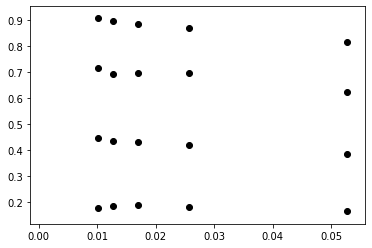

time: 6min 32s


In [0]:
import matplotlib.pyplot as plt

def puiss3_bis(delta, sigma, alpha, n_permutations, n_simulations):
    n_rejections = 0

    for _ in range(n_simulations):
        x1, x2 = genereDonnees(delta, sigma, 8, 4)
        t_obs = calculeT(x1, x2)

        p_value = approxP(x1, x2, t_obs, n_permutations)
        if p_value < alpha:
            n_rejections += 1
     
    return n_rejections / n_simulations

deltas = [0.5, 1, 1.5, 2]
alpha = 0.05
sigmas = [1]

results = {}

n_simulations = 4000
n_permutations = [99, 79, 59, 39, 19]

for n_permutation in n_permutations:
    for sigma in sigmas:
        for delta in deltas:
            exp_name = (delta, n_permutation)
            results[exp_name] = puiss3_bis(delta, sigma, alpha, n_permutation, n_simulations)

# affichage des points
for k, v in results.items():
    plt.scatter(1/k[1], v, label=f"{k}", color='k')

"""
x = np.array([1/val for val in n_permutations]).reshape(-1, 1)
y = np.array(n_rejections)

clf = LinearRegression()
clf.fit(x, y)

predict = clf.predict(np.array(0).reshape(-1, 1))
"""
plt.show()